In [266]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import random
from torch import tensor
sns.set()

In [2]:
def generate_random_colors(num_colors):
    colors = []
    for i in range(num_colors):
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        colors.append('#{:02x}{:02x}{:02x}'.format(red, green, blue))
        
    return colors

In [308]:
class ResultsAnalysis:
    
    def __init__(self, yaml_path, noise_level: int = 0):
        
        self.class_names = ('Disturbed Galaxies', 'Merging Galaxies', 
        'Round Smooth Galaxies', 'In-between Round Smooth Galaxies', 
        'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 
        'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 
        'Edge-on Galaxies without Bulge', 'Edge-on Galaxies with Bulge')
    
        self.noise_level = noise_level
        with open(yaml_path, "r") as f:
            data = yaml.safe_load(f)
            
        models = []
        accuracies = []
        for model_name, model_data in data.items():
            # Create a dictionary to store the data for each class
            class_data = {}

            for class_name, class_metrics in model_data.items():
                    # Add the metrics for the class to the dictionary
                    if isinstance(class_metrics, dict):
                        class_data[class_name] = {
                            "f1-score": class_metrics["f1-score"],
                            "precision": class_metrics["precision"],
                            "recall": class_metrics["recall"],
                            "support": class_metrics["support"]
                        }
                    else:
                        accuracies.append(class_metrics)
                        
            models.append({
                "Model": model_name,
                **{f"{class_name.lower()} - {metric_name}": class_metrics[metric_name] for class_name, class_metrics in class_data.items() for metric_name in class_metrics}
            })

        # Create a pandas dataframe from the list of dictionaries
        self.df = pd.DataFrame(models)
        self.df['Accuracy'] = accuracies
        
    def plot_heatmap(self):
        self.df_filtered = self.df[self.df.index != "Accuracy"].drop(columns=['Accuracy'])
        self.df_filtered = self.df_filtered.set_index("Model")
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'support' in col])
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'precision' in col])
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'recall' in col])
        # Transpose the dataframe so that models are on the x-axis and classes are on the y-axis
        self.df_transposed = self.df_filtered.transpose()
        
        # Set the size of the plot
        plt.figure(figsize=(8, 4))

        # Create the heatmap
        sns.heatmap(self.df_transposed, annot=False, cmap="Blues")

        # Set the title and axis labels
        plt.title(f"F1 Scores (Noise Level: {self.noise_level}%)")
        plt.xlabel("Model")
        plt.ylabel("F1-Score")

        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=45, ha="right")

        # Show the plot
        # plt.show()
        
    def plot_accuracy(self, ax=None):
        model_names = self.df["Model"].tolist()
        accuracies = self.df['Accuracy'].tolist()

        # Sort the model names and accuracy values in descending order of accuracy
        model_names, accuracies = zip(*sorted(zip(model_names, accuracies), key=lambda x: x[1], reverse=True))

        # Set the size of the plot
        if ax is None:
            fig, ax = plt.subplots()

        # Create a horizontal bar chart showing the accuracy for each model
        bars = ax.barh(model_names, accuracies)

        # Set the color of the bars to indicate the accuracy, with red for the worst performing model and green for the best performing model
        for i, bar in enumerate(bars):
            if i == 0:
                bar.set_color("g")
            elif i == len(bars) - 1:
                bar.set_color("r")
            else:
                bar.set_color("gray")

        # Add labels and a title to the chart
        ax.set_xlabel("Accuracy")
        ax.set_title(f"Model Accuracies (Noise Level: {self.noise_level}%)")

    def plot_precision_recall(self, class_name: str):
        class_name = class_name.lower()
        models = self.df['Model'].unique()
        models_list = ', '.join(models).split(', ')
        colors = plt.cm.tab20(np.arange(20))

        additional_colors = np.random.rand(5, 3)
        if additional_colors.shape[1] < colors.shape[1]:
            additional_colors = np.hstack([additional_colors, np.ones((5, colors.shape[1] - additional_colors.shape[1]))])
        colors = np.vstack([colors, additional_colors])

        precision_col = [col for col in self.df.columns if 'precision' in col.lower() and class_name in col.lower()][0]
        recall_col = [col for col in self.df.columns if 'recall' in col.lower() and class_name in col.lower()][0]

        for i, model_name in enumerate(models_list):
            model_data = self.df[self.df['Model'] == model_name]
            plt.scatter(model_data[recall_col], model_data[precision_col], label=model_name, color=colors[i])

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{class_name.title()} Precision-Recall Scatter Plot (Noise Level: {self.noise_level}%)')
        plt.legend(bbox_to_anchor=(1.05, 1.05))
        plt.show()
        


In [309]:
tm = ResultsAnalysis("/Users/snehpandya/Projects/GCNNMorphology/data/test_metrics.yaml", 0)
tm25 = ResultsAnalysis("/Users/snehpandya/Projects/GCNNMorphology/data/test_metrics_25.yaml", 75)
tm50 = ResultsAnalysis("/Users/snehpandya/Projects/GCNNMorphology/data/test_metrics_50.yaml", 50)
tm75 = ResultsAnalysis("/Users/snehpandya/Projects/GCNNMorphology/data/test_metrics_75.yaml", 25)


In [310]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# plot1 = tm.plot_accuracy(0, ax=axs[0, 0])
# plot2 = tm25.plot_accuracy(75, ax=axs[1, 1])
# plot3 = tm50.plot_accuracy(50, ax=axs[1, 0])
# plot4 = tm75.plot_accuracy(25, ax=axs[0, 1])

# fig.tight_layout()
# plt.savefig('../../plots/accuracies.png')
# plt.show()

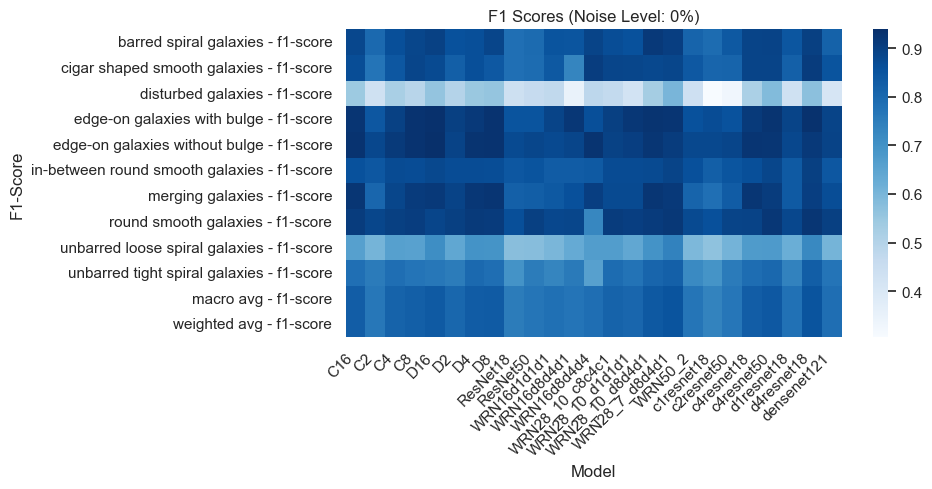

In [313]:
tm.plot_heatmap()